# This notebook is to perform inference using a ubteacherv2 trained Faster-RCNN model to find lesions
Serving as a precursor to a standalone inference script

Author: Jesse Chao
e-mail: jesse.chao@sri.utoronto.ca

In [2]:
# Imports

import os
from pathlib import Path
import sys
from typing import *
import joblib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import shutil

from pprint import pprint

from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
)

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import tifffile as tf
import torch

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

import ROI_detection2.utils.train_utils as train_utils

from ubteacher.config import add_ubteacher_config;

In [ ]:
def scale_poly(base_img_shape: np.ndarray, 
               target_img_shape: np.ndarray or tuple, 
               polygon: np.ndarray) -> np.ndarray:
    """Scale an input polygon to the desired image dimension
    Args:
    base_img_shape -- shape of input image, channel last (if present)
    target_img_shape -- shape of target image, channel last (if present)
    Return:
    scaled_polygon
    """
    base_long_edge = max(base_img_shape[0], base_img_shape[1])
    target_long_edge = max(target_img_shape[0], target_img_shape[1])
    scale_factor = round(target_long_edge/ base_long_edge, 3)
    scaled_polygon = np.multiply(polygon, scale_factor)
    return np.array(np.int32(scaled_polygon))

In [ ]:
def polygon2bbox(polygon: np.ndarray, pad: float=0.02) -> List:
    """Convert segmentation polygons to 
    bounding boxes. Add padding
    Args:
    polygon -- segmentation polygon
    padding -- fraction of the original width
                to pad the boxes by
    Returns:
    box in XYXY
    """
    # Grab bounding box from polygon
    x0 = min(polygon[:, 0])
    y0 = min(polygon[:, 1])
    x1 = max(polygon[:, 0])
    y1 = max(polygon[:, 1])
    w = x1 - x0
    h = y1 - y0
    # Add padding
    x0 = max(0, x0-w*pad)
    x1 = x1 + w*pad
    y0 = max(0, y0-h*pad)
    y1 = y1 + h*pad
    return [x0, y0, x1, y1]

In [ ]:
def search_recursive(d: Dict, key: str) -> Iterator:
    """Helper function for finding which level of json annotations has
    the matching key.
    """
    for k, v in d.items():
        if isinstance(v, Dict):
            for match in search_recursive(v, key):
                yield match
        if k == key:
            # generator function - saves in memory until called
            # (use for loop to call)
            yield v

This image has 6 pages, 3 levels:
(32337, 33863, 3)
(8084, 8465, 3)
(2021, 2116, 3)


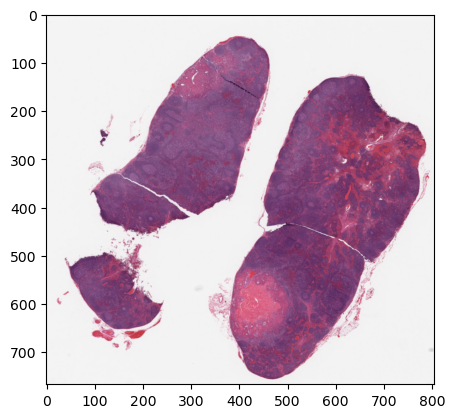

In [3]:
#src_dir = "/mnt/d/SynologyDrive/SRI_OSCC_lymph_test" # WSL
#src_dir = "/mnt/MT8/SynologyDrive/SRI_OSCC_lymph_test" # Linux
src_dir = "/mnt/FNX/SynologyDrive/Datasets_pathology/SRI_OSCC_lymph_test/" #FN Linux
image_id = "Case 14 F11"
image_ext = ".svs"
image_file = os.path.join(src_dir, image_id+image_ext)
max_dim = 800
# Read WSI header and get some info
with tf.TiffFile(image_file) as slide:
    print(
        f"This image has {len(slide.pages)} pages, {len(slide.series[0].levels)} levels:"
    )
    for i in slide.series[0].levels:
        print(i.shape)
    # Get image thumbnail
    image_thumbnail = train_utils.TrainUtil(max_dim).find_top(slide)
    # Set image dimension attributes
    target_dim = image_thumbnail.shape
    base_dim = slide.series[0].levels[0].shape
    base_dim = train_utils.channel_last(base_dim)
    # Display image
    fig, ax = plt.subplots()
    ax.imshow(image_thumbnail)
    plt.show(); plt.close()

In [7]:
# Load trained model from config and weights
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.PARENTDIR = ""
cfg.merge_from_file("../completed_outputs/COCOPath_Pretraining_1005/config.yaml")
cfg.MODEL.WEIGHTS = "../completed_outputs/COCOPath_Pretraining_1005/model_0199999.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

In [8]:
with torch.no_grad():
    outputs = predictor(image_thumbnail)
instances = outputs["instances"].to("cpu")
instances.get_fields()

/home/jessechao/miniconda3/envs/AI_path/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'pred_boxes': Boxes(tensor([[392.0922, 524.6846, 509.2122, 678.3793]])),
 'scores': tensor([0.7566]),
 'pred_classes': tensor([0]),
 'pred_boxes_std': tensor([[-1.3257, -1.4527, -1.5793, -1.5405]])}

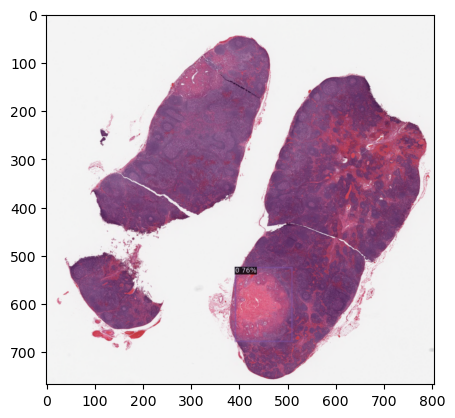

In [9]:
v = Visualizer(image_thumbnail[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(instances)
plt.imshow(v.get_image()[:, :, ::-1])
plt.show(); plt.close()